In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import pprint
from ipynb.fs.full.aco import ACO, Graph
from ipynb.fs.full.plot import plot

In [2]:
filename = "xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

#To just give yourself a name for accessing OpenStreetMap database
geolocator = Nominatim(user_agent = 'ashish', timeout=10000)

In [3]:
def time_cost(loc1, loc2, passenger_count, store_and_fwd_flag):
    '''
    Estimate trip duration in minutes using XGBoost model
    '''
    
    #enter date for calculations
    date_list = [10, 4, 2016] #April 10 2016
    
    #extract parameters
    day = int(date_list[0])
    month = int(date_list[1])
    year = int(date_list[2])
    
    date = datetime.date(year, month, day)
    
    model_input = {
        'passenger_count': passenger_count,
        'pickup_longitude': loc1['x'],
        'pickup_latitude': loc1['y'],
        'dropoff_longitude': loc2['x'],
        'dropoff_latitude': loc2['y'],
        'store_and_fwd_flag': bool(store_and_fwd_flag),
        'mm_pickup': date.month,
        'dow_pickup': date.weekday(),
        'day_pickup': date.day,
        'hour_pickup': 22,
        'min_pickup': 4,
        'latitude_difference': loc2['y'] - loc1['y'],
        'longitude_difference': loc2['x'] - loc1['x'],
        'trip_distance': tripDistance(loc1, loc2)
    }
    
    df = pd.DataFrame([model_input], columns = model_input.keys())
    y_ = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return y_[0]

In [4]:
def tripDistance(loc1, loc2):
    '''
    Calculate distance travelled in kilometer as per the Haversine Formula for Latitude_difference and longitude_difference
        #Haversine formula - the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points (ignoring any hills they fly over, of course!).
        #source: https://www.movable-type.co.uk/scripts/latlong.html
    '''
    R = 6371 #Radius of earth
    phi1 = loc2['y'] * np.pi / 180
    phi2 = loc1['y'] * np.pi / 180
    Dlat = np.abs((loc2['y'] - loc1['y']) * np.pi / 180)
    Dlong = np.abs((loc2['x'] - loc1['x']) * np.pi / 180)
    
    a = np.sin(Dlat / 2) * np.sin(Dlat / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(Dlong / 2) * np.sin(Dlong / 2)
    c = 2 * np.arctan2(np.sqrt(np.abs(a)), np.sqrt(np.abs(1-a)))
    trip_distance = R * c
    
    return trip_distance

In [5]:
#user inputs
location_count = 15
ant_count = 10
g = 100
alpha = 1.0
beta = 10.0
rho = 0.5
q = 10.0
verbose = True

In [6]:
locations = []
points = []
#Read user specified number of lines
df = pd.read_csv(filepath_or_buffer = 'test.csv', delimiter = ',', engine = 'c', parse_dates = [2], low_memory = True)[:location_count]

for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    
    points.append((row['pickup_longitude'], row['pickup_latitude']))
    
print(df)

           id  vendor_id     pickup_datetime  passenger_count  \
0   id3004672          1 2016-06-30 23:59:58                1   
1   id3505355          1 2016-06-30 23:59:53                1   
2   id1217141          1 2016-06-30 23:59:47                1   
3   id2150126          2 2016-06-30 23:59:41                1   
4   id1598245          1 2016-06-30 23:59:33                1   
5   id0668992          1 2016-06-30 23:59:30                1   
6   id1765014          1 2016-06-30 23:59:15                1   
7   id0898117          1 2016-06-30 23:59:09                2   
8   id3905224          2 2016-06-30 23:58:55                2   
9   id1543102          2 2016-06-30 23:58:46                1   
10  id3024712          1 2016-06-30 23:58:32                4   
11  id3665810          2 2016-06-30 23:58:05                1   
12  id1836461          1 2016-06-30 23:58:01                1   
13  id3457080          2 2016-06-30 23:57:57                1   
14  id3376065          1 

In [7]:
#Build cost matrix with elements as time taken to travel between two points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost(locations[i], locations[j], 1, 0))
    cost_matrix.append(row)

In [8]:
#Passing user inputs to ACO
aco = ACO(ant_count = ant_count, generations = g, alpha = alpha, beta = beta, rho = rho, q = q, strategy = 2)

#Build Graph with cost_matrix and number of points
graph = Graph(cost_matrix, rank)

#Results from ACO
best_path, cost, avg_costs, best_costs = aco.solve(graph, verbose)

#Print the result
print("Final Cost: {} minutes, Path: {}".format(cost, best_path))

Generation #1 best cost: 109.58496522903442, avg cost: 118.77662920951843, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #2 best cost: 109.58496522903442, avg cost: 131.2634949684143, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #3 best cost: 109.58496522903442, avg cost: 119.53770351409912, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #4 best cost: 109.58496522903442, avg cost: 130.63141512870789, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #5 best cost: 109.58496522903442, avg cost: 109.58496522903442, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #6 best cost: 109.58496522903442, avg cost: 123.53994274139404, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #7 best cost: 109.58496522903442, avg cost: 135.69499230384827, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #8 best cost: 109.58496522903442, avg cost: 123.53994274139404, pa

Generation #66 best cost: 109.58496522903442, avg cost: 123.53994274139404, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #67 best cost: 109.58496522903442, avg cost: 128.77646708488464, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #68 best cost: 109.58496522903442, avg cost: 130.17961049079895, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #69 best cost: 109.58496522903442, avg cost: 135.69499230384827, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #70 best cost: 109.58496522903442, avg cost: 124.62065148353577, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #71 best cost: 109.58496522903442, avg cost: 132.12252640724182, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #72 best cost: 109.58496522903442, avg cost: 127.11340880393982, path: [12, 3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10]
Generation #73 best cost: 109.58496522903442, avg cost: 129.554093122

In [9]:
#Print out final addresses mean and standard deviation
print("Minimum cost (mean):", format(np.mean(best_costs)))
print("Minimum cost (standard deviation):", format(np.std(best_costs)))

Minimum cost (mean): 109.58496522903442
Minimum cost (standard deviation): 0.0


Final addresses:
Position 1 : 28-48, 31st Street, Queens, Queens County, New York, 11102, United States of America
Position 2 : 1477, 2nd Avenue, Lenox Hill, Manhattan Community Board 8, Manhattan, New York County, New York, 10021, United States of America
Position 3 : Ritz Tower, East 57th Street, Midtown East, Manhattan Community Board 5, Manhattan, New York County, New York, 10022, United States of America
Position 4 : Americas Tower, 1177, 6th Avenue, Midtown, Manhattan Community Board 5, Manhattan, New York County, New York, 10019, United States of America
Position 5 : Pennsylvania Station, 9th Avenue, Hudson Yards, Manhattan Community Board 4, Manhattan, New York County, New York, 10019, United States of America
Position 6 : 210, West 30th Street, Chelsea, Manhattan Community Board 5, Manhattan, New York County, New York, 10001, United States of America
Position 7 : Fashion Institute of Technology, 8th Avenue, Chelsea, Manhattan Community Board 4, Manhattan, New York County, New 

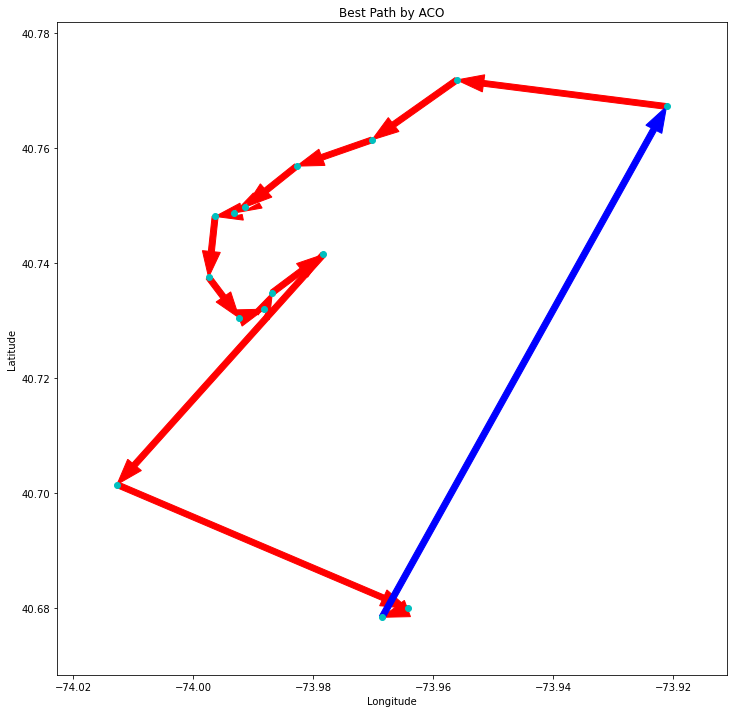

In [13]:
#Print out final addresses in solution
if verbose:
    print("Final addresses:")
    try:
        addresses = []
        for p in best_path:
            addresses.append(geolocator.reverse(f"{points[p][1]}, {points[p][0]}").address)
            
        for i in range(len(addresses)):
            print("Position " + str(i+1) + " : " + addresses[i])
        #pprint.pprint(addresses)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed with message {e}")
        
plot(points, best_path)

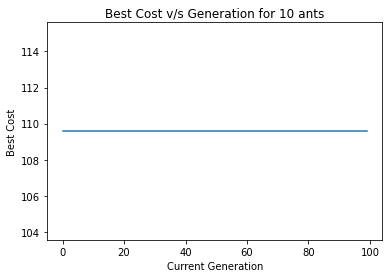

In [14]:
x_values = [i for i in range(g)]
plt.title("Best Cost v/s Generation for " + str(ant_count) + " ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

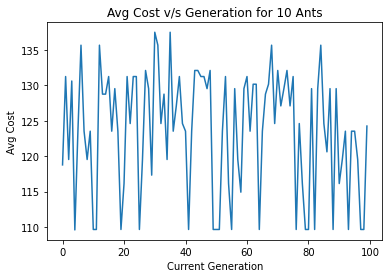

In [12]:
x_values = [i for i in range(g)]
plt.title("Avg Cost v/s Generation for " + str(ant_count) + " Ants")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()